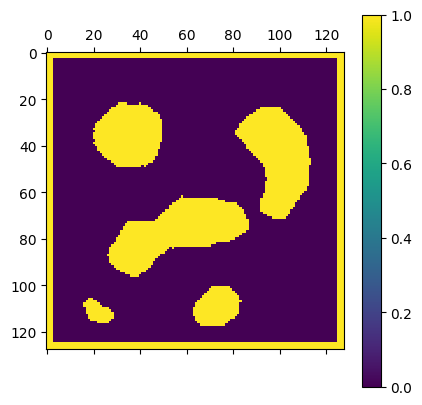

In [86]:
import numpy as np
import math
from matplotlib import pyplot as plt
from PIL import Image
import random
import math
import time

from Point import Point

# Load the image and convert to grayscale
image_path = "../data/map0.png"
image = Image.open(image_path).convert("L")

# Convert image data to numpy array and normalize
grid_map = np.array(image.getdata()).reshape(image.size[1], image.size[0]) / 255

# Binarize the image: convert to binary values (0 for free space, 1 for obstacles)
threshold = 0.5  # Adjust threshold if needed
grid_map[grid_map > threshold] = 1
grid_map[grid_map <= threshold] = 0

# Invert colors to make 0 -> free and 1 -> occupied
grid_map = (grid_map * -1) + 1

# Build C space
C = []
for i, row in enumerate(grid_map):
    for j, cell in enumerate(row):
        if cell == 0:
            C.append([i, j])


# Visualize the grid map
plt.matshow(grid_map)
plt.colorbar()
plt.show()


In [87]:
def rand_config(grid_map, p, q_goal):
    # Return goal with probability p, otherwise sample random point
    if np.random.rand() < p:
        return q_goal
    else:
        # generate random coordinats within the grid bounds
        x = np.random.uniform(0, grid_map.shape[0] - 1)
        y = np.random.uniform(0, grid_map.shape[1] - 1)
        # Return a Point object with the random coordinates
        return Point(x, y)

def nearest_vertex(q_rand, G):
    # Find the vertex in G closest to q_rand
    vertices = G["vertices"]
    smallest_distance = float('inf')
    nearest_vertex = None
    # for each vertex in the graph
    for vertex in vertices:
        distance = q_rand.dist(vertex) # calculate the distance from q_rand to the current vertex
        if distance < smallest_distance: # is distance smaller than the smallest distance found so far
            smallest_distance = distance # update the smallest distance
            nearest_vertex = vertex   #Update the nearest vertex
   
    return nearest_vertex

def new_config(q_near, q_rand, delta_q):
    # Move from q_near towards q_rand by delta_q
    delta_x = q_rand.x - q_near.x
    delta_y = q_rand.y - q_near.y
    distance = q_near.dist(q_rand) # calculate the distance between q_near and q_rand
    if distance == 0: # If it iis zero, return q_near
        return q_near
    # normalize the direction vector 
    direction = [delta_x / distance, delta_y / distance]
    move_x = direction[0] * delta_q
    move_y = direction[1] * delta_q
    new_x = round(q_near.x + move_x)
    new_y = round(q_near.y + move_y)
    # add a new Point object with the new coordinates
    q_new = Point(new_x, new_y)
    # check if the new point overshoot the target
    if q_near.dist(q_new) > distance:  # if yes, set q_new to be the same as q_rand
        q_new = Point(q_rand.x, q_rand.y)
    return q_new

def is_segment_free_inc(q_near, q_new, C):
    # Check if segment between q_near and q_new is free from obstacles
    num_samples = int(max(abs(q_new.x - q_near.x), abs(q_new.y - q_near.y)) + 1)
    # Generate evenly spaced coordinates between q_near and q_new
    x_coords = np.linspace(q_near.x, q_new.x, num_samples).astype(int)
    y_coords = np.linspace(q_near.y, q_new.y, num_samples).astype(int)
    for x, y in zip(x_coords, y_coords):
        
        if [x, y] not in C: # Is the current point in the obstacle-free list C
            return False # collision
    # all points are obstacle-free
    return True

def add_vertex(G, vertex):
    # Append the new vertex to the graph's vertex list
    G["vertices"].append(vertex)

def add_edge(G, vertex_1, vertex_2):
    # Append the new edge to the graph's edge list
    G["edges"].append((vertex_1, vertex_2))


In [ ]:
def fill_path(vertices, edges):
    if not edges:
        return vertices, edges, []  

    edges.reverse()  # reverse edge list
    path = [edges[0][1]]  # start path with the first endpoint
    next_v = edges[0][0]  # set the next vertex
    i = 1
    start_vertex = vertices[0]  # set start vertex

    while next_v != start_vertex:
        found = False
        while i < len(edges):
            if edges[i][1] == next_v:  # find the next segment in path
                path.append(edges[i][1])  # append to path
                next_v = edges[i][0]
                found = True
                break
            i += 1
        if not found:
            break  # if no matching edge is found, exit

    path.append(start_vertex)  # complete the path
    edges.reverse()  # restore original edge order
    path.reverse()  # correct path order
    return vertices, edges, path 

def path_distance(path):
    # calculate the total distance of the path
    path_distance = 0
    for i in range(1, len(path)):
        path_distance += path[i - 1].dist(path[i])
    path_distance = round(path_distance, 2) 
    return path_distance

def plot_RRT(grid_map, vertices, edges, q_start, q_goal, path=None):
    plt.figure(figsize=(10, 10))
    plt.matshow(grid_map, fignum=0)  # Display the grid map
    
    # plot vertices
    for vertex in vertices:
        plt.plot(vertex.y, vertex.x, 'k+')  

    # plot edges
    for edge in edges:
        p1, p2 = edge
        plt.plot([p1.y, p2.y], [p1.x, p2.x], '--g')  

    plt.plot(q_start.y, q_start.x, "g*")  
    plt.plot(q_goal.y, q_goal.x, "b*") 

    # plot the path if it exists
    if path:
        plt.plot([p.y for p in path], [p.x for p in path], '-r')  ç

    plt.show() 

In [89]:
# we used the pseudo-code from the lab manual
def RRT(grid_map, C, K, delta_q, p, q_start, q_goal):
    G = {
        "vertices": [q_start],                  # initialize the graph with the starting point and empty edge list
        "edges": []  
    }

    min_dist = 1  # set minimum distance to consider goal reached
    path = None  

    for k in range(1, K):

        q_rand = rand_config(grid_map, p, q_goal)
        q_near = nearest_vertex(q_rand, G)
        q_new = new_config(q_near, q_rand, delta_q)

        if is_segment_free_inc(q_near, q_new, C):         # check if the path from q_near to q_new is collision-free
            add_vertex(G, q_new)     # add the new configuration to the graph
            add_edge(G, q_near, q_new)   # connect the nearest vertex to the new configuration
            if q_new.dist(q_goal) < min_dist:     # check if the new configuration is close enough to the goal
                add_edge(G, q_new, q_goal) # if yems, connect the new configuration directly to the goal
                vertices, edges, path = fill_path(G["vertices"], G["edges"]) # generate the path from start to goal
                return G, k, path 

    print("No path found.")  # no path is found within the iterations
    return G, k, path 

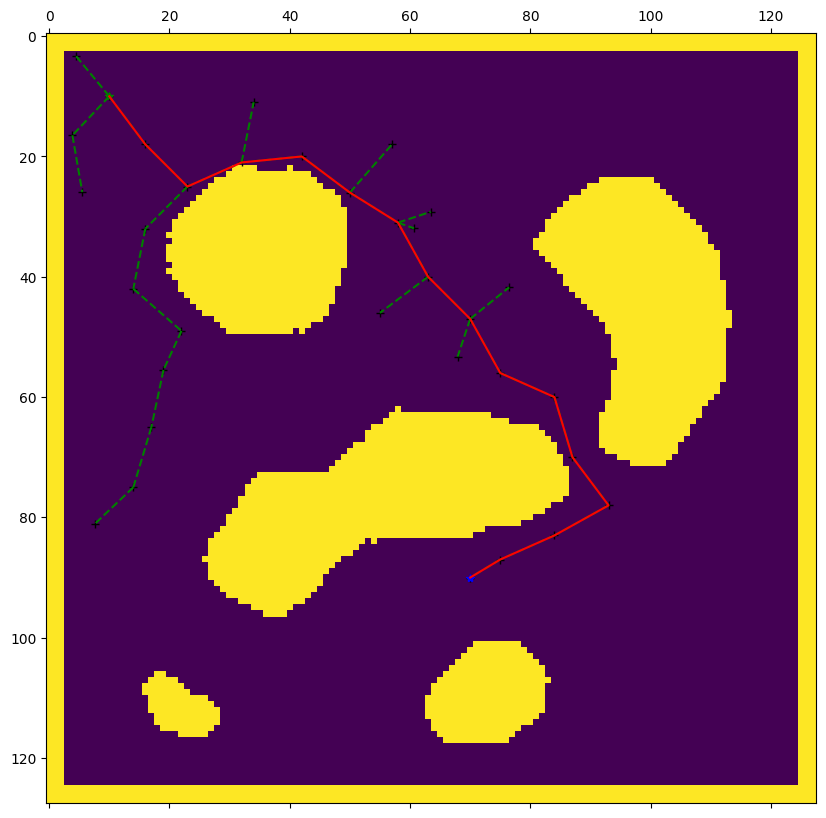

Given K = 10000, delta_q = 10, p = 0.2, and min_dist = 1
Path found in 60 iterations
Path distance: 145.99
Path to follow:
[(10, 10), (18, 16), (25, 23), (21, 32), (20, 42), (26, 50), (31, 58), (40, 63), (47, 70), (56, 75), (60, 84), (70, 87), (78, 93), (83, 84), (87, 75), (90, 70), (90, 70)]


In [90]:
q_start = Point(10, 10)
q_goal = Point(90, 70)
K = 10000
deltaq = 10
p = 0.2
min_dist = 1
G, k, path = RRT(grid_map, C, K, deltaq, p, q_start, q_goal)
vertices = G["vertices"]
edges = G["edges"]

if path:
    distance = path_distance(path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, path)
    print(f"Given K = {K}, delta_q = {deltaq}, p = {p}, and min_dist = {min_dist}")
    print(f"Path found in {k} iterations")
    print(f"Path distance: {distance}")
    print("Path to follow:")
    print([(p.x, p.y) for p in path])
else:
    print("No solution found.")


In [91]:
def smooth_path(path, C):
    n = len(path)
    smoothed_path = [path[0]]
    i = 0
    j = n - 1

    while i < n - 1:  # stop when we reach the goal
        j = n - 1   # set j to the goal node

        # find the farthest node j that can be connected to i
        while j > i and not is_segment_free_inc(path[i], path[j], C):
            j = j - 1

        # add the farthest reachable node to the smoothed path
        smoothed_path.append(path[j])
        i = j  # move to the next segment

    return smoothed_path

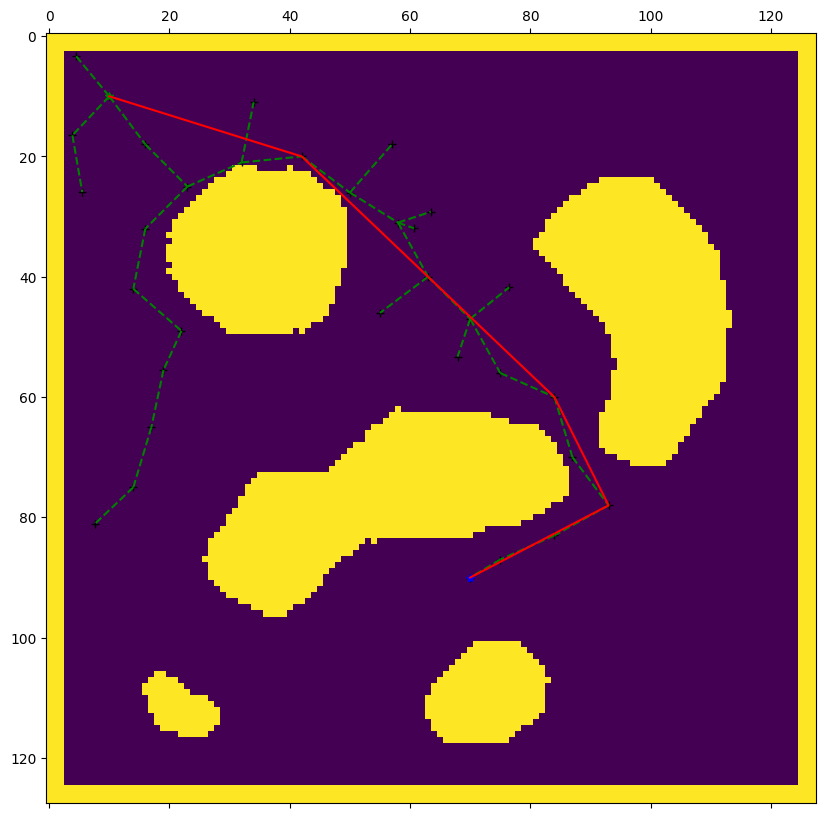

Smoothed path distance: 137.59
Smoothed path to follow:
[(10, 10), (20, 42), (60, 84), (78, 93), (90, 70)]


In [92]:
# Visualize the smoothed solution
if path:
    smoothed_path = smooth_path(path, C)
    distance = path_distance(smoothed_path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, smoothed_path)
    print(f"Smoothed path distance: {distance}")
    print("Smoothed path to follow:")
    print([(p.x,p.y) for p in smoothed_path])
else:
    print("No solution found.")

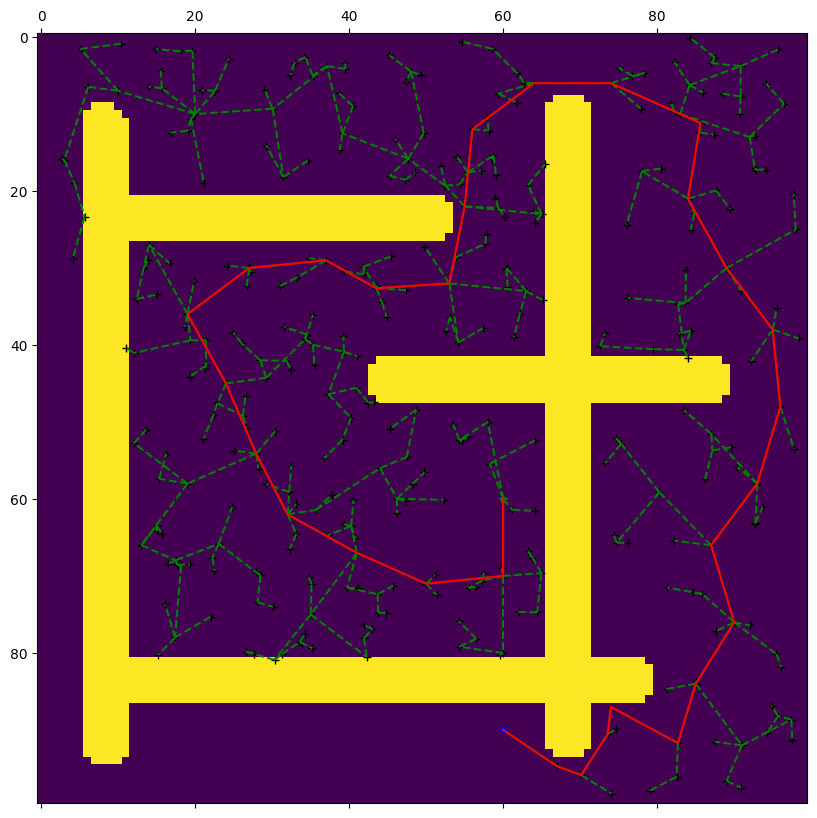

Given K = 10000, delta_q = 10, q = 0.2
Path found in 805 iterations
Path distance: 279.48
Path to follow:
[(60, 60), (70, 60), (71, 50), (67, 41), (62, 32), (54.105599802858116, 27.91562195923424), (45, 24), (36, 19), (30, 27), (29, 37), (32.62599483015951, 43.52322820343688), (32, 53), (22, 55), (12, 56), (6, 64), (6, 74), (10, 83), (11.202360548634621, 85.62424223724753), (21, 84), (30, 89), (38, 95), (48, 96), (58, 93), (66, 87), (76, 90), (84, 85), (91.70981561103419, 82.69289095295117), (87, 74), (90.54356721393825, 73.55668558247133), (95.86938365314309, 70.12420826908956), (94.67299822626973, 66.95184381501505), (90, 60), (90, 60)]


In [60]:
q_start = Point(60, 60)
q_goal = Point(90, 60)
K = 10000
deltaq = 10
p = 0.2
G, k, path = RRT(grid_map, C, K, deltaq, p, q_start, q_goal)
vertices = G["vertices"]
edges = G["edges"]

# Visualize the solution
if path:
    distance = path_distance(path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, path)
    print(f"Given K = {K}, delta_q = {deltaq}, q = {p}")
    print(f"Path found in {k} iterations")
    print(f"Path distance: {distance}")
    print("Path to follow:")
    print([(p.x, p.y) for p in path])
else:
    print("No solution found.")

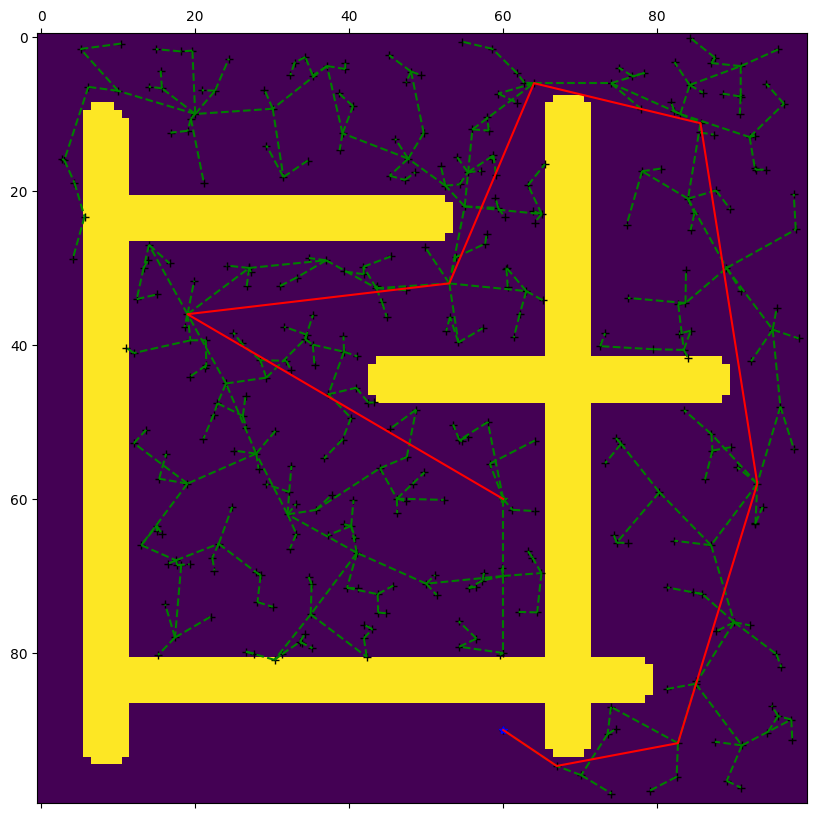

Smoothed path distance: 239.23
Smoothed path to follow:
[(60, 60), (36, 19), (32, 53), (6, 64), (11.202360548634621, 85.62424223724753), (58, 93), (91.70981561103419, 82.69289095295117), (94.67299822626973, 66.95184381501505), (90, 60)]


In [61]:

# Visualize the smoothed solution
if path:
    smoothed_path = smooth_path(path, C)
    distance = path_distance(smoothed_path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, smoothed_path)
    print(f"Smoothed path distance: {distance}")
    print("Smoothed path to follow:")
    print([(p.x,p.y) for p in smoothed_path])
else:
    print("No solution found.")

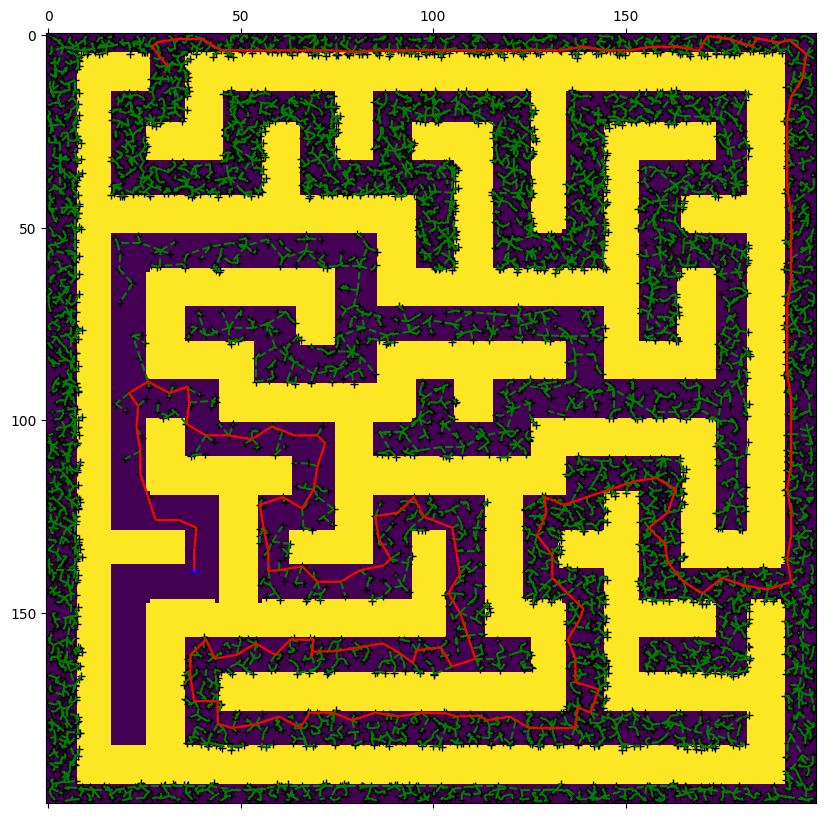

Given K = 50000, delta_q = 6, p = 0.2, and min_dist = 1.0
Path found in 33796 iterations
Path distance: 993.53
Path to follow:
[(8, 31), (3, 27), (1.8555154582034654, 28.316849032864795), (1, 34), (1, 40), (4, 45), (4, 51), (4, 57), (4, 63), (4, 69), (4, 75), (4.39309805383676, 79.1295401692129), (4, 85), (4, 91), (4, 97), (4, 103), (4, 109), (4, 115), (4, 121), (4, 127), (4, 133), (3, 139), (4, 145), (4, 151), (3, 157), (3, 163), (4, 169), (0.2280461770997484, 171.3469940701399), (1, 177), (3, 183), (0.7858918821569478, 183.9334994842183), (2, 190), (1.2004013244036424, 192.4869232853113), (5, 197), (11, 196), (16, 193), (22, 192), (28, 192), (34, 192), (40, 192), (46, 193), (52, 193), (58, 193), (64, 193), (70, 192), (76, 192), (82, 192), (88, 192), (94, 193), (100, 193), (106, 193), (112, 193), (118, 192), (124, 193), (130, 193), (136, 192), (142, 193), (144, 187), (143, 181), (141, 175), (145, 170), (142, 165), (137, 161), (132.0692665149135, 160.22901206818068), (128, 156), (124, 

In [66]:

q_start = Point(8, 31)
q_goal = Point(139, 38)
K = 50000
deltaq = 6
p = 0.2
min_dist = 1.0  # Example minimum distance for goal selection

# Run the RRT algorithm
G, k, path = RRT(grid_map, C, K, deltaq, p, q_start, q_goal)
vertices = G["vertices"]
edges = G["edges"]

# Visualize the solution
if path:
    distance = path_distance(path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, path)
    print(f"Given K = {K}, delta_q = {deltaq}, p = {p}, and min_dist = {min_dist}")
    print(f"Path found in {k} iterations")
    print(f"Path distance: {distance}")
    print("Path to follow:")
    print([(p.x, p.y) for p in path])
else:
    print("No solution found.")


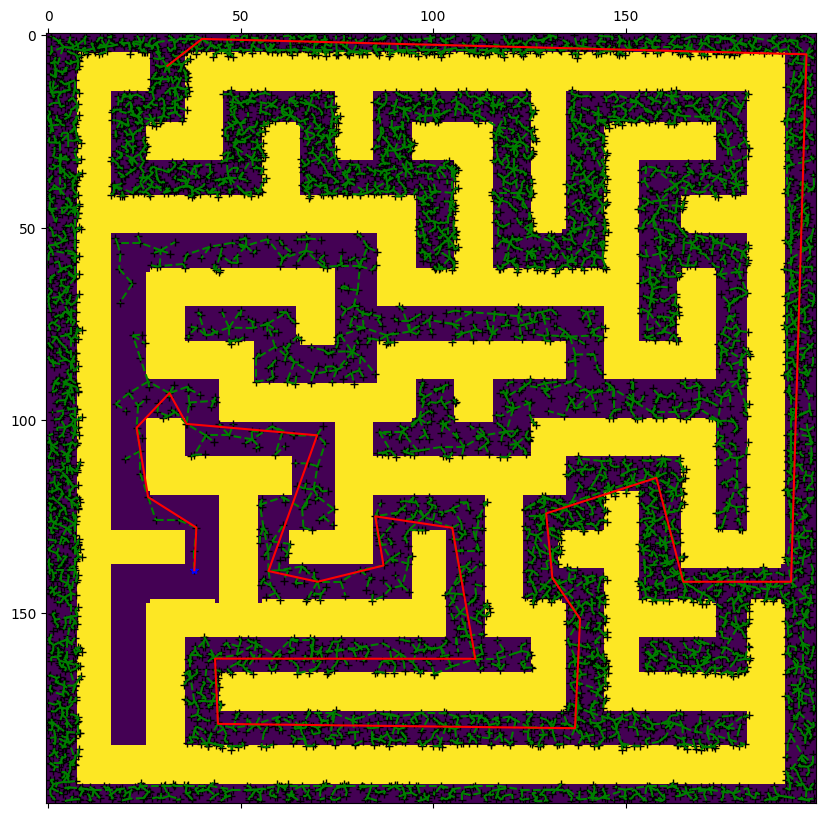

Smoothed path distance: 862.48
Smoothed path to follow:
[(8, 31), (1, 40), (5, 197), (142, 193), (142, 165), (115, 158), (124.25407966360463, 129.39133544729336), (141, 131), (151.64849366536632, 138.19320237539472), (180.03952081247212, 136.88053459962757), (178.90812680646866, 44.13632524067544), (161.9601180536918, 43.37697695657982), (162, 111), (128, 105), (125, 85), (137.7745846145475, 87.1422648035159), (142, 70), (139.2149659199082, 57.26551723436651), (103.96311405204987, 69.89426736537155), (101, 36), (93.00635326508483, 31.52850467609121), (102, 23), (120, 26), (127.92488235773898, 38.53104728339061), (139, 38)]


In [67]:
# Visualize the smoothed solution
if path:
    smoothed_path = smooth_path(path, C)
    distance = path_distance(smoothed_path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, smoothed_path)
    print(f"Smoothed path distance: {distance}")
    print("Smoothed path to follow:")
    print([(p.x,p.y) for p in smoothed_path])
else:
    print("No solution found.")

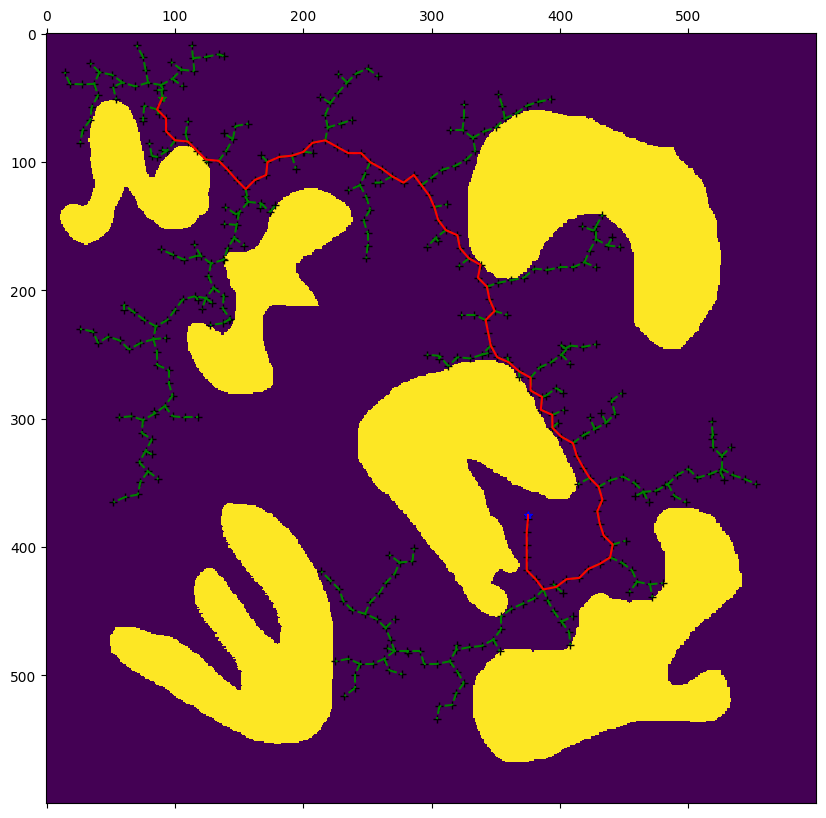

Given K = 10000, delta_q = 10, q = 0.2
Path found in 931 iterations
Path distance: 766.02
Path to follow:
[(50, 90), (59, 86), (66, 93), (76, 93), (83, 100), (84, 110), (91, 117), (98, 124), (99, 134), (106, 141), (114, 148), (121, 155), (114, 162), (110, 171), (100, 172), (96, 181), (95, 191), (92, 200), (85, 207), (83, 217), (88, 226), (93, 235), (93, 245), (100, 252), (105, 261), (111, 269), (116, 278), (110, 286), (118, 292), (126, 298), (135, 302), (145, 305), (153, 311), (157, 320), (167, 322), (175, 329), (180, 338), (190, 336), (197, 343), (207, 345), (216, 349), (223, 342), (233, 344), (243, 346), (252, 351), (256, 360), (263, 368), (268, 377), (278, 377), (283, 386), (293, 385), (297, 394), (307, 394), (314, 401), (319, 410), (329, 413), (338, 418), (346, 423), (353, 430), (363, 433), (372, 429), (382, 431), (391, 434), (398, 441), (408, 439), (413, 431), (417, 422), (424, 415), (425, 405), (431, 397), (433, 387), (425, 381), (418, 374), (408, 374), (398, 374), (388, 374), (3

In [13]:
q_start = Point(50, 90)
q_goal = Point(375, 375)
K = 10000
deltaq = 10
p = 0.2
G, k, path = RRT(grid_map, C, K, deltaq, p, q_start, q_goal)
vertices = G["vertices"]
edges = G["edges"]

# Visualize the solution
if path:
    distance = path_distance(path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, path)
    print(f"Given K = {K}, delta_q = {deltaq}, q = {p}")
    print(f"Path found in {k} iterations")
    print(f"Path distance: {distance}")
    print("Path to follow:")
    print([(p.x, p.y) for p in path])
else:
    print("No solution found.")

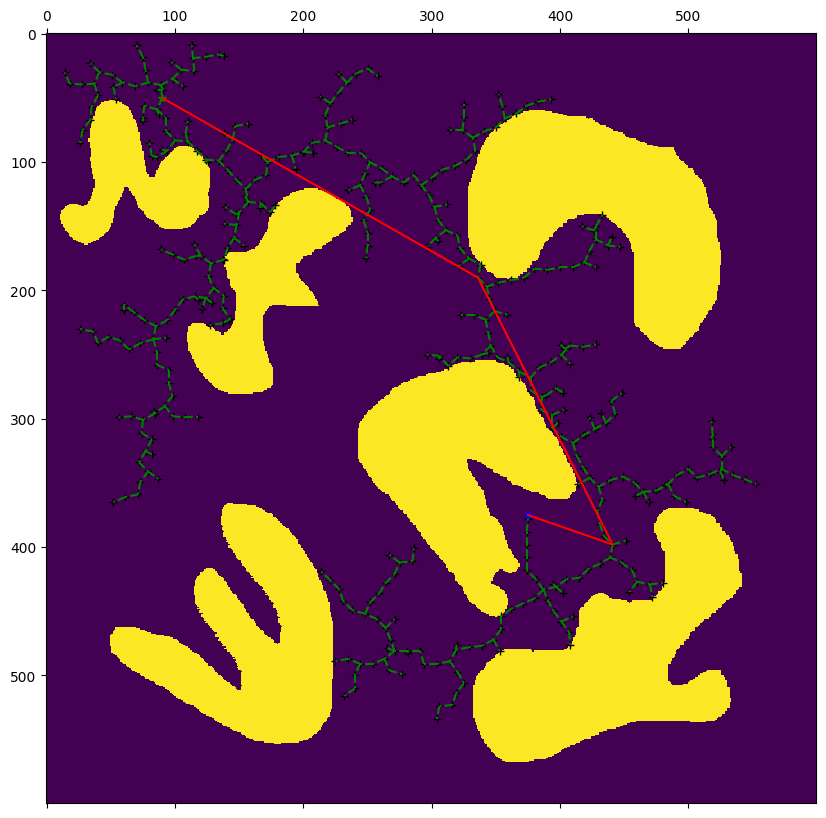

Smoothed path distance: 585.94
Smoothed path to follow:
[(50, 90), (190, 336), (398, 441), (375, 375)]


In [ ]:

# Visualize the smoothed solution
if path:
    smoothed_path = smooth_path(path, C)
    distance = path_distance(smoothed_path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, smoothed_path)
    print(f"Smoothed path distance: {distance}")
    print("Smoothed path to follow:")
    print([(p.x,p.y) for p in smoothed_path])
else:
    print("No solution found.")

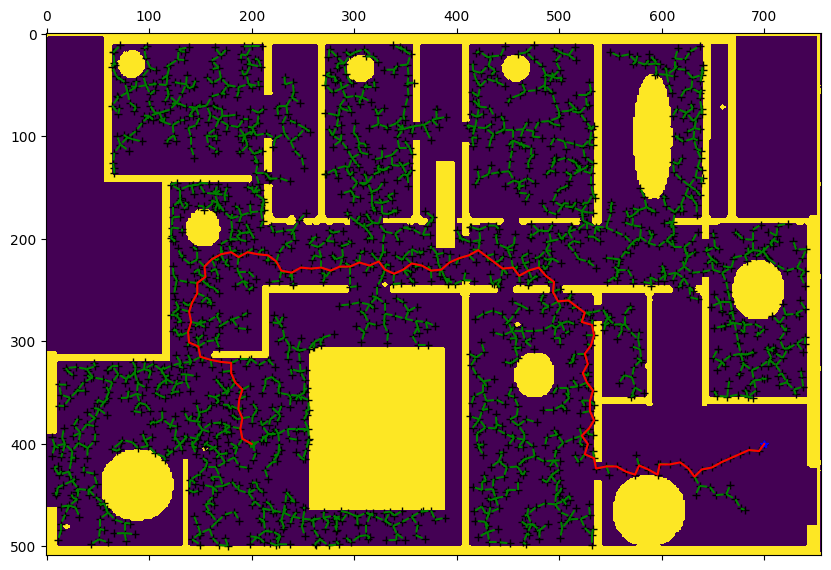

Given K = 20000, delta_q = 10, q = 0.2
Path found in 5355 iterations
Path distance: 1044.21
Path to follow:
[(400, 200), (395, 191), (385, 189), (375, 191), (366, 187), (356, 188), (347, 191), (340, 184), (331, 180), (321, 180), (320, 170), (318, 160), (315, 150), (305, 148), (301, 139), (291, 138), (281, 141), (271, 139), (262, 142), (253, 147), (243, 147), (237, 155), (227, 154), (220, 161), (215, 170), (213, 180), (217.76018272959612, 187.3014685645066), (213, 196), (215, 206), (216, 216), (222, 224), (231, 229), (233, 239), (228, 248), (229, 258), (228, 268), (231, 277), (227, 286), (227, 296), (223, 305), (226, 315), (222, 324), (230, 330), (234, 339), (230, 348), (224, 356), (226, 366), (231, 375), (230, 385), (223, 393), (219, 402), (216, 412), (211, 421), (217, 429), (223, 437), (229, 445), (228, 455), (236, 461), (231, 470), (228, 480), (236, 487), (242, 495), (252, 494), (261, 499), (260, 509), (266, 517), (272, 525), (281, 522), (284, 532), (294, 534), (304, 531), (312, 525)

In [70]:
q_start = Point(400, 200)
q_goal = Point(400, 700)
K = 20000
deltaq = 10
p = 0.2
G, k, path = RRT(grid_map, C, K, deltaq, p, q_start, q_goal)
vertices = G["vertices"]
edges = G["edges"]

# Visualize the solution
if path:
    distance = path_distance(path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, path)
    print(f"Given K = {K}, delta_q = {deltaq}, q = {p}")
    print(f"Path found in {k} iterations")
    print(f"Path distance: {distance}")
    print("Path to follow:")
    print([(p.x, p.y) for p in path])
else:
    print("No solution found.")

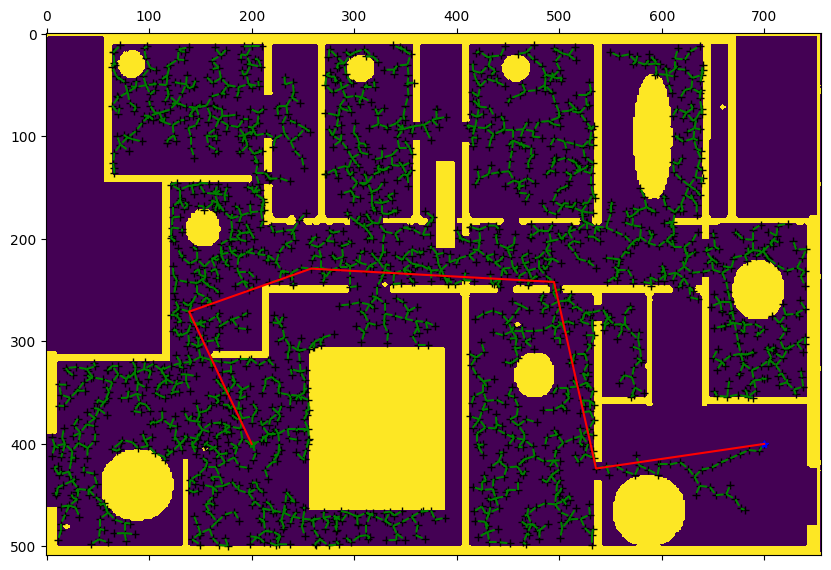

Smoothed path distance: 858.55
Smoothed path to follow:
[(400, 200), (271, 139), (229, 258), (242, 495), (424, 536), (400, 700)]


In [73]:
# Visualize the smoothed solution
if path:
    smoothed_path = smooth_path(path, C)
    distance = path_distance(smoothed_path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, smoothed_path)
    print(f"Smoothed path distance: {distance}")
    print("Smoothed path to follow:")
    print([(p.x,p.y) for p in smoothed_path])
else:
    print("No solution found.")

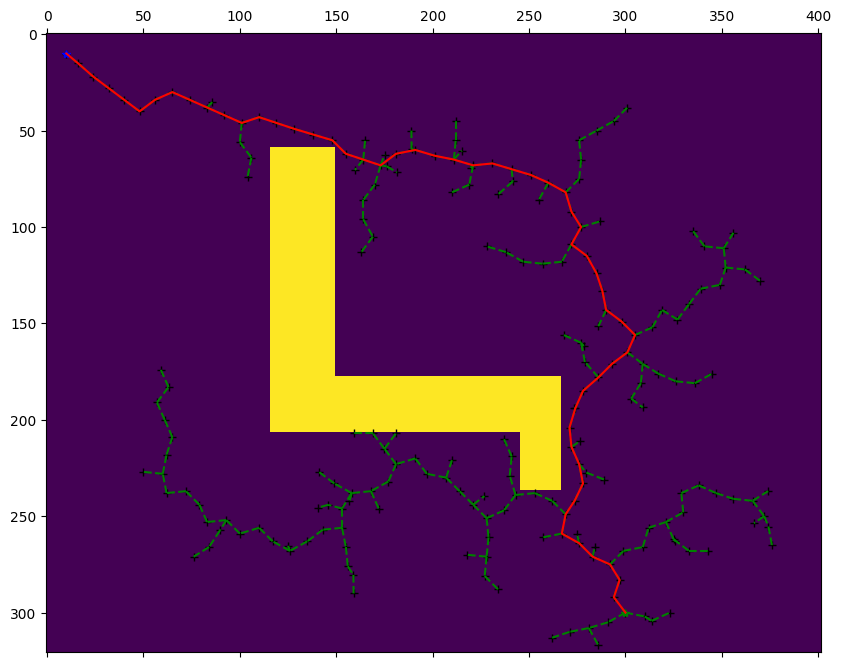

Given K = 1000, delta_q = 10, q = 0.2
Path found in 290 iterations
Path distance: 556.63
Path to follow:
[(300, 300), (292, 294), (283, 297), (275, 292), (271, 283), (264, 276), (259, 267), (249, 269), (241.9402625090707, 273.679584394985), (233, 278), (223, 276), (214, 272), (204, 271), (194, 274), (185, 278), (178, 286), (171, 293), (165, 301), (156, 305), (149, 298), (143, 290), (133, 288), (124, 285), (115, 280), (109, 272), (100, 277), (92, 272), (82, 269), (77, 260), (73, 251), (70, 241), (67, 231), (68, 221), (65, 211), (63, 201), (60, 191), (62, 181), (68, 173), (65, 164), (62, 155), (55, 148), (52, 138), (49, 128), (46, 119), (43, 110), (46, 101), (42, 92), (38, 83), (34, 74), (30, 65), (34, 56), (40, 48), (34, 40), (28, 32), (22, 24), (15, 16), (10, 10), (10, 10)]


In [75]:
q_start = Point(300, 300)
q_goal = Point(10,10)
K = 1000
deltaq = 10 
p = 0.2
G, k, path = RRT(grid_map, C, K, deltaq, p, q_start, q_goal)
vertices = G["vertices"]
edges = G["edges"]

# Visualize the solution
if path:
    distance = path_distance(path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, path)
    print(f"Given K = {K}, delta_q = {deltaq}, q = {p}")
    print(f"Path found in {k} iterations")
    print(f"Path distance: {distance}")
    print("Path to follow:")
    print([(p.x, p.y) for p in path])
else:
    print("No solution found.")

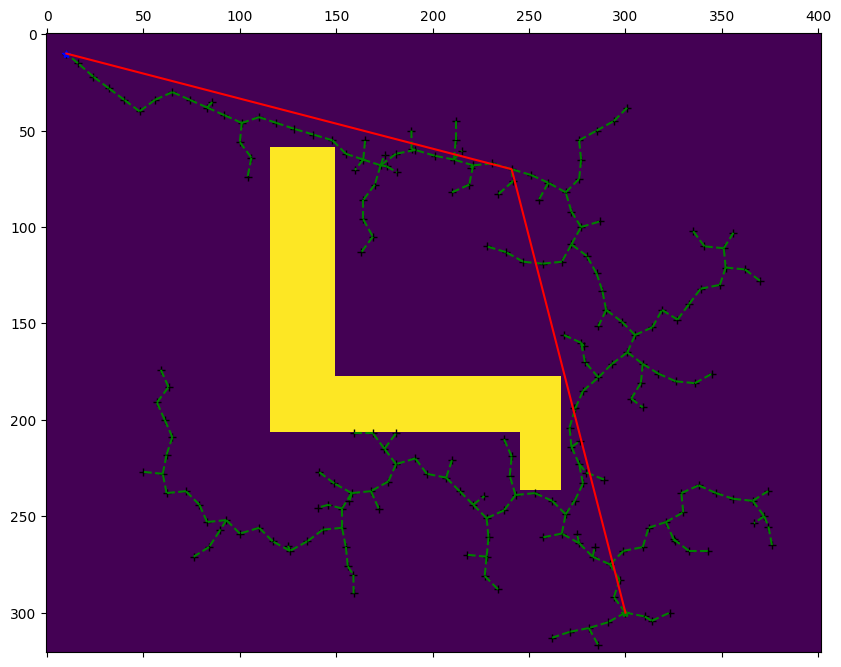

Smoothed path distance: 476.11
Smoothed path to follow:
[(300, 300), (70, 241), (10, 10)]


In [76]:
# Visualize the smoothed solution
if path:
    smoothed_path = smooth_path(path, C)
    distance = path_distance(smoothed_path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, smoothed_path)
    print(f"Smoothed path distance: {distance}")
    print("Smoothed path to follow:")
    print([(p.x,p.y) for p in smoothed_path])
else:
    print("No solution found.")

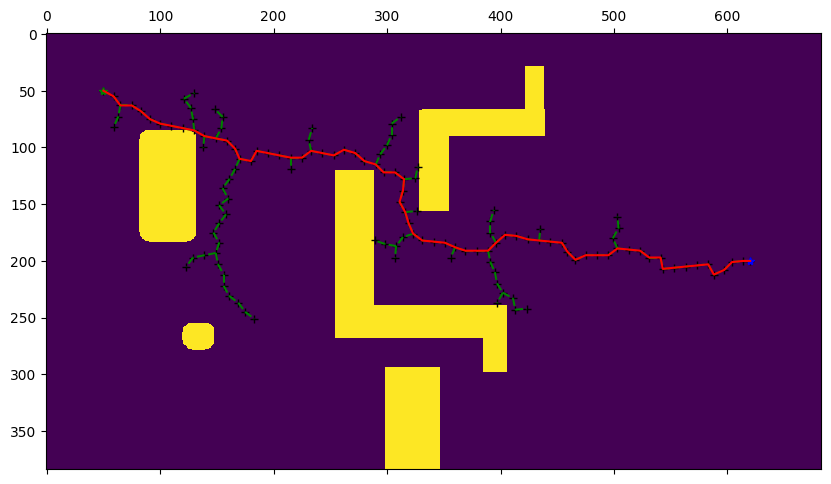

Given K = 1000, delta_q = 10, q = 0.2
Path found in 137 iterations
Path distance: 691.89
Path to follow:
[(50, 50), (55, 59), (63, 65), (63, 75), (68, 83), (75, 91), (79, 100), (81, 110), (83, 120), (85, 130), (90, 139), (92, 149), (94, 159), (101, 166), (110, 170), (112, 180), (103, 185), (105, 195), (107, 205), (109, 215), (109, 225), (103, 233), (105, 243), (107, 253), (102, 262), (105, 272), (112, 280), (115, 290), (122, 297), (122, 307), (128, 315), (138, 314), (148, 311), (157, 316), (167, 319), (176, 323), (182, 331), (183, 341), (184, 351), (188, 360), (191, 369), (191, 379), (191, 389), (184, 396), (177, 404), (178, 414), (181, 424), (182, 434), (183, 444), (184, 454), (192, 459), (199, 466), (195, 475), (195, 485), (195, 495), (189, 503), (190, 513), (191, 523), (197, 531), (197, 541), (207, 543), (206, 553), (205, 563), (204, 573), (203, 583), (212, 588), (208, 597), (201, 604), (200, 614), (200, 620), (200, 620)]


In [78]:
q_start = Point(50, 50)
q_goal = Point(200, 620)
K = 1000
deltaq = 10
p = 0.2
G, k, path = RRT(grid_map, C, K, deltaq, p, q_start, q_goal)
vertices = G["vertices"]
edges = G["edges"]

# Visualize the solution
if path:
    distance = path_distance(path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, path)
    print(f"Given K = {K}, delta_q = {deltaq}, q = {p}")
    print(f"Path found in {k} iterations")
    print(f"Path distance: {distance}")
    print("Path to follow:")
    print([(p.x, p.y) for p in path])
else:
    print("No solution found.")

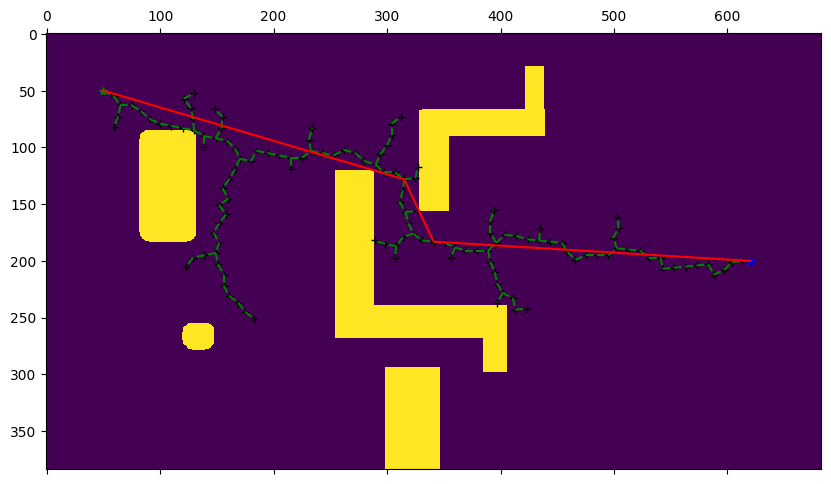

Smoothed path distance: 616.59
Smoothed path to follow:
[(50, 50), (128, 315), (183, 341), (200, 620)]


In [79]:
# Visualize the smoothed solution
if path:
    smoothed_path = smooth_path(path, C)
    distance = path_distance(smoothed_path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, smoothed_path)
    print(f"Smoothed path distance: {distance}")
    print("Smoothed path to follow:")
    print([(p.x,p.y) for p in smoothed_path])
else:
    print("No solution found.")

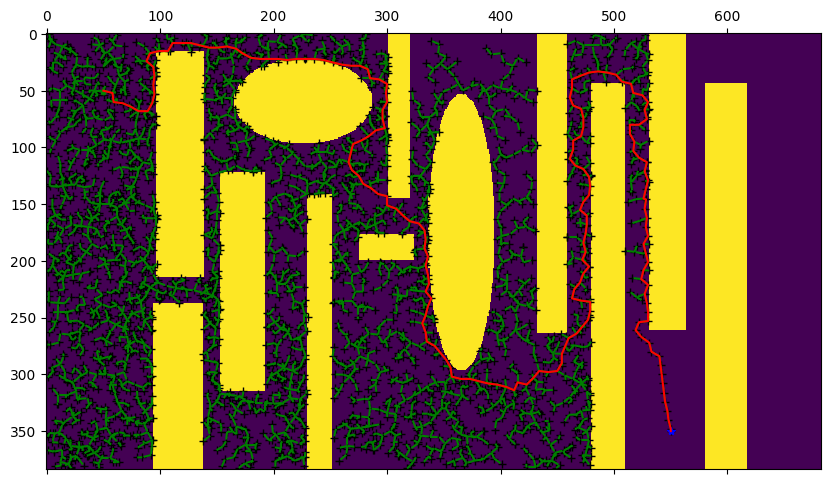

Given K = 30000, delta_q = 8, q = 0.2
Path found in 10363 iterations
Path distance: 1494.04
Path to follow:
[(50, 50), (52, 58), (60, 59), (61, 67), (64, 74), (68, 81), (68, 89), (61, 93), (53, 95), (45, 94), (37, 95), (29, 94), (24, 88), (17, 91), (15, 99), (15, 107), (8, 111), (8, 119), (8, 127), (10, 135), (12, 143), (12, 151), (11, 159), (13, 167), (17.068860048050183, 172.65467204854997), (21, 180), (22, 188), (22, 196), (22, 204), (23, 212), (22, 220), (22, 228), (22, 236), (23, 244), (25, 252), (27, 260), (28, 268), (28, 276), (31, 283), (39, 285), (40, 293), (44, 300), (52, 299), (60, 300), (67, 296), (75, 296), (83, 298), (85, 290), (90, 284), (94, 277), (97, 270), (105, 268), (113, 266), (120, 269), (125, 275), (132, 279), (136, 286), (141, 292), (143, 300), (151, 300), (154, 308), (160, 314), (165, 320), (167, 328), (173, 333), (181, 334), (189, 333), (196, 336), (204, 334), (212, 336), (220, 337), (227, 334), (233, 339), (240, 336), (248, 334), (255, 331), (263, 334), (271,

In [81]:
q_start = Point(50, 50)
q_goal = Point(350,550)
K = 30000
deltaq = 8
p = 0.2
G, k, path = RRT(grid_map, C, K, deltaq, p, q_start, q_goal)
vertices = G["vertices"]
edges = G["edges"]

# Visualize the solution
if path:
    distance = path_distance(path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, path)
    print(f"Given K = {K}, delta_q = {deltaq}, q = {p}")
    print(f"Path found in {k} iterations")
    print(f"Path distance: {distance}")
    print("Path to follow:")
    print([(p.x, p.y) for p in path])
else:
    print("No solution found.")

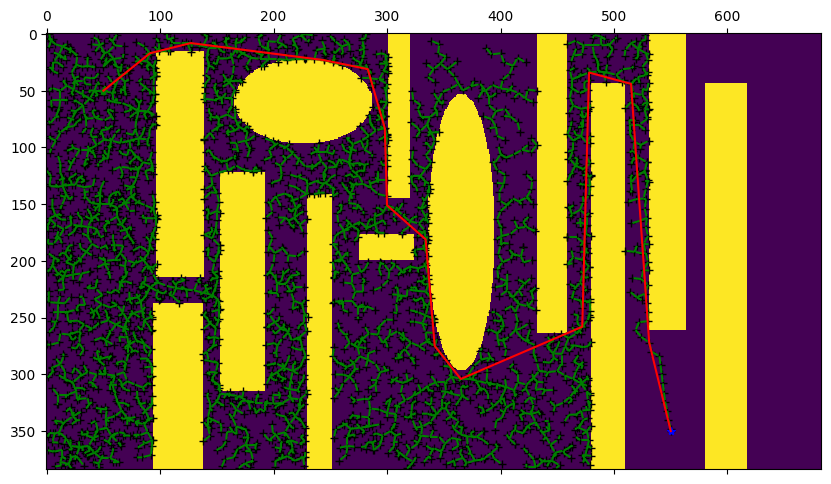

Smoothed path distance: 1234.07
Smoothed path to follow:
[(50, 50), (17, 91), (8, 127), (23, 244), (31, 283), (83, 298), (151, 300), (181, 334), (275, 342), (304, 365), (258, 472), (34, 478), (44, 515), (272, 531), (350, 550)]


In [82]:
# Visualize the smoothed solution
if path:
    smoothed_path = smooth_path(path, C)
    distance = path_distance(smoothed_path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, smoothed_path)
    print(f"Smoothed path distance: {distance}")
    print("Smoothed path to follow:")
    print([(p.x,p.y) for p in smoothed_path])
else:
    print("No solution found.")

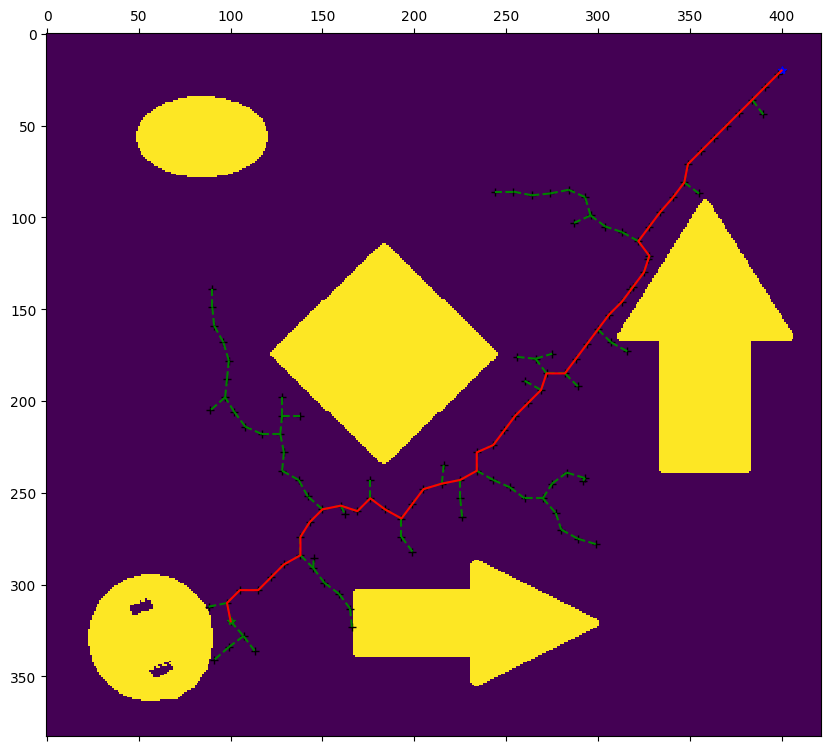

Given K = 10000, delta_q = 10, q = 0.2
Path found in 125 iterations
Path distance: 481.81
Path to follow:
[(320, 100), (310, 98), (303, 105), (303, 115), (296, 122), (289, 129), (284, 138), (274, 138), (266, 143), (259, 150), (257, 160), (260, 169), (253, 176), (259, 184), (264, 193), (256, 199), (248, 205), (245, 215), (243, 225), (238, 234), (228, 234), (224, 243), (216, 249), (208, 255), (201, 262), (194, 269), (185, 272), (185, 282), (177, 288), (169, 294), (161, 300), (153, 306), (146, 313), (138, 319), (130, 325), (121, 328), (113, 322), (105, 328), (97, 334), (89, 341), (81, 347), (71, 349), (64, 356), (57, 363), (50, 370), (43, 377), (36, 384), (29, 391), (22, 398), (20, 400), (20, 400)]


In [84]:
q_start = Point(320, 100)
q_goal = Point(20,400)
K = 10000
deltaq = 10
p = 0.2
G, k, path = RRT(grid_map, C, K, deltaq, p, q_start, q_goal)
vertices = G["vertices"]
edges = G["edges"]

# Visualize the solution
if path:
    distance = path_distance(path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, path)
    print(f"Given K = {K}, delta_q = {deltaq}, q = {p}")
    print(f"Path found in {k} iterations")
    print(f"Path distance: {distance}")
    print("Path to follow:")
    print([(p.x, p.y) for p in path])
else:
    print("No solution found.")

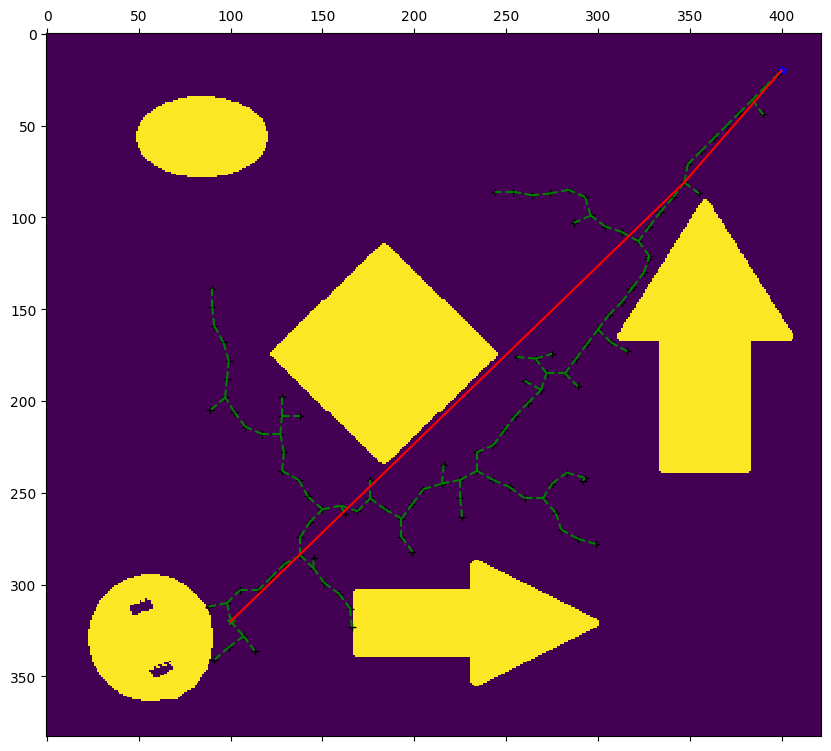

Smoothed path distance: 424.51
Smoothed path to follow:
[(320, 100), (81, 347), (20, 400)]


In [85]:
# Visualize the smoothed solution
if path:
    smoothed_path = smooth_path(path, C)
    distance = path_distance(smoothed_path)
    plot_RRT(grid_map, vertices, edges, q_start, q_goal, smoothed_path)
    print(f"Smoothed path distance: {distance}")
    print("Smoothed path to follow:")
    print([(p.x,p.y) for p in smoothed_path])
else:
    print("No solution found.")